In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import os
import numpy as np

from matplotlib.lines import Line2D

from matplotlib.colors import ListedColormap
colors = ["#005845", "#84C497", "#F28E77", "#64C1CB", "#F3A44C"]
syke5 = ListedColormap(colors)

models = ['yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x']
model_path = Path('../runs')

# Cross-validation

Evaluate the cross-validation performance of different YOLOv8 models.

Metrics used here are the following:

* $Precision = \frac{tp}{tp+fp}$, with IoU-threshold of 0.5
* $Recall = \frac{tp}{tp+fn}$, with IoU-threshold of 0.5
* $mAP50$ is the area under the precision-recall curve with IoU threshold of 0.5
* $mAP$ or $AP@[.5:.95]$ is the average $mAP$ for IoU from 0.5 to 0.95 with a step size of 0.05
* $IoU$ corresponds to Intersection-over-Union, the ratio between the overlap and union of two bounding boxes

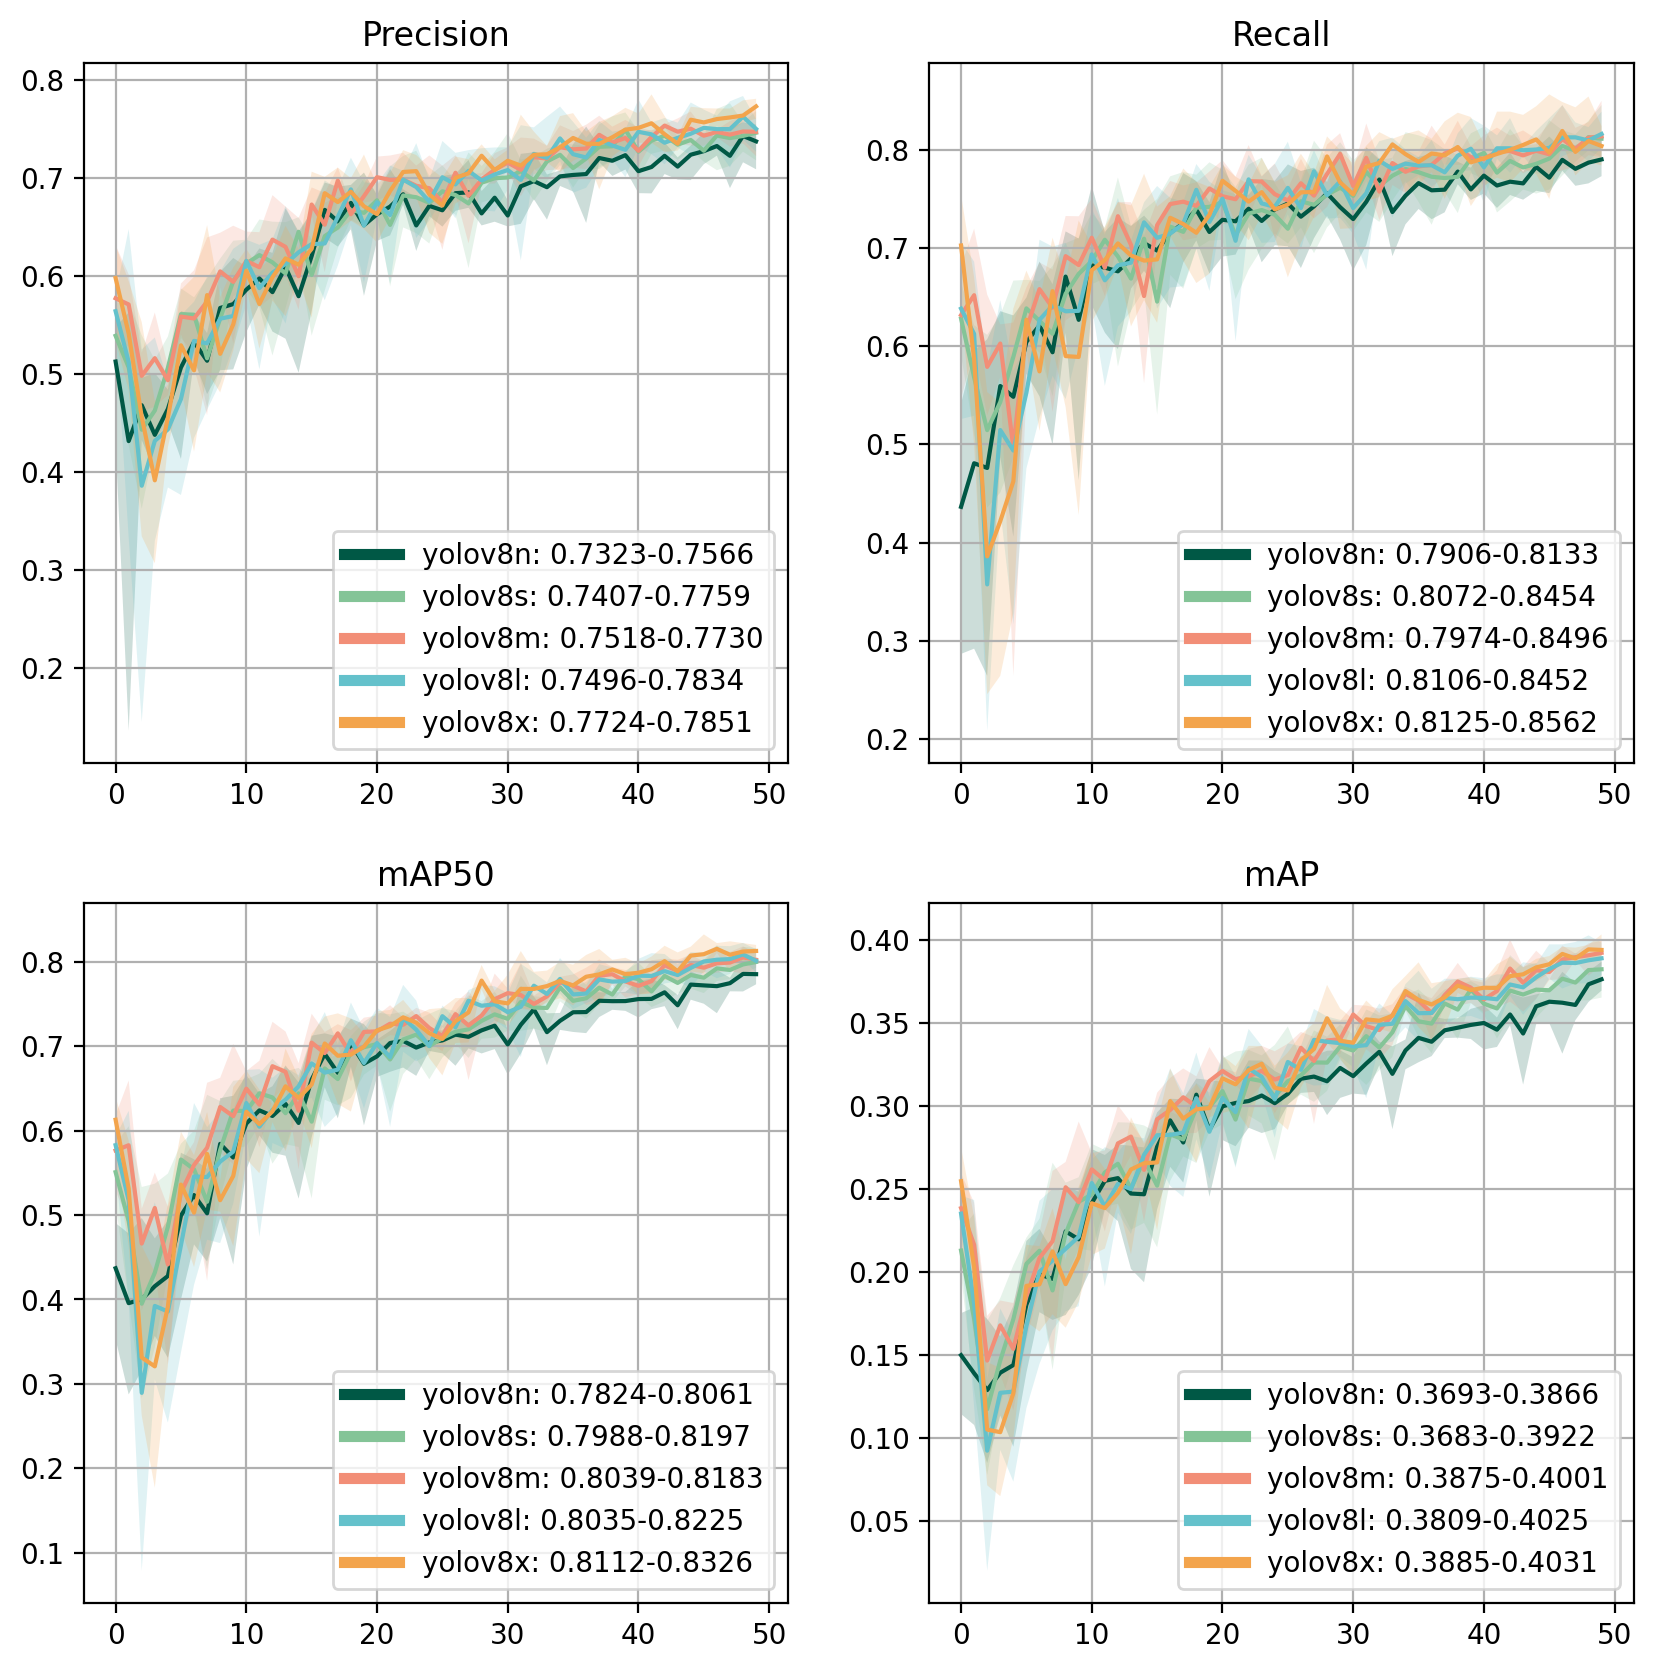

In [115]:
#| echo: False
#| label: fig-cvres
#| fig-cap: 5-fold crossvalidation results for different model architectures."

fig, axs = plt.subplots(2,2, dpi=200, figsize=(10,10))

custom_lines = [Line2D([0], [0], color=syke5(0.0), lw=4),
                Line2D([0], [0], color=syke5(.25), lw=4),
                Line2D([0], [0], color=syke5(.50), lw=4),
                Line2D([0], [0], color=syke5(.75), lw=4),
                Line2D([0], [0], color=syke5(1.0), lw=4),]

pres = []
recs = []
mAP50s = []
mAPs = []

for i, m in enumerate(models):
    folds = os.listdir(model_path/m)
    pre = []
    rec = []
    mAP50 = []
    mAP = []
    for f in folds:
        if not os.path.exists(model_path/m/f/'results.csv'): continue
        res = pd.read_csv(model_path/m/f/'results.csv')
        res.rename(columns=lambda x: x.strip(), inplace=True)
        pre.append(res['metrics/precision(B)'])
        rec.append(res['metrics/recall(B)'])
        mAP50.append(res['metrics/mAP50(B)'])
        mAP.append(res['metrics/mAP50-95(B)'])
    axs[0,0].plot(np.array(pre).mean(axis=0), color=colors[i])
    axs[0,0].fill_between(range(0,50),
                          np.array(pre).min(axis=0),
                          np.array(pre).max(axis=0),
                          color=colors[i], alpha=0.2,
                          edgecolor='none')
    axs[0,1].plot(np.array(rec).mean(axis=0), color=colors[i])
    axs[0,1].fill_between(range(0,50),
                          np.array(rec).min(axis=0),
                          np.array(rec).max(axis=0),
                          color=colors[i], alpha=0.2,
                          edgecolor='none')
    axs[1,0].plot(np.array(mAP50).mean(axis=0), color=colors[i])
    axs[1,0].fill_between(range(0,50),
                          np.array(mAP50).min(axis=0),
                          np.array(mAP50).max(axis=0),
                          color=colors[i], alpha=0.2,
                          edgecolor='none')
    axs[1,1].plot(np.array(mAP).mean(axis=0), color=colors[i])
    axs[1,1].fill_between(range(0,50),
                          np.array(mAP).min(axis=0),
                          np.array(mAP).max(axis=0),
                          color=colors[i], alpha=0.2,
                          edgecolor='none')
    pres.append((np.array(pre).max(axis=1).min(), np.array(pre).max(axis=1).max()))
    recs.append((np.array(rec).max(axis=1).min(), np.array(rec).max(axis=1).max()))
    mAP50s.append((np.array(mAP50).max(axis=1).min(), np.array(mAP50).max(axis=1).max()))
    mAPs.append((np.array(mAP).max(axis=1).min(), np.array(mAP).max(axis=1).max()))
    
axs[0,0].set_title('Precision')
axs[0,1].set_title('Recall')
axs[1,0].set_title('mAP50')
axs[1,1].set_title('mAP')

axs[0,0].legend(custom_lines, [f'{m}: {pres[i][0]:.4f}-{pres[i][1]:.4f}' for i, m in enumerate(models)], loc=4)
axs[0,1].legend(custom_lines, [f'{m}: {recs[i][0]:.4f}-{recs[i][1]:.4f}' for i, m in enumerate(models)], loc=4)
axs[1,0].legend(custom_lines, [f'{m}: {mAP50s[i][0]:.4f}-{mAP50s[i][1]:.4f}' for i, m in enumerate(models)], loc=4)
axs[1,1].legend(custom_lines, [f'{m}: {mAPs[i][0]:.4f}-{mAPs[i][1]:.4f}' for i, m in enumerate(models)], loc=4)

for a in axs.flatten(): a.grid()    
plt.show()

Dark line is the average of the metric during the corresponding epoch, and shaded areas show the best and worst values.

# Test set results

Example results are acquired with the `yolov8x` model with best validation score. The predictions are also cleaned using the following steps:

1. All prediction whose centroid points are not located on water are discarded. The water mask used contains layers `jarvi` (Lakes), `meri` (Sea) and `virtavesialue` (Rivers as polygon geometry) from the Topographical database by the National Land Survey of Finland. Unfortunately this also discards all points not within the Finnish borders.
2. All predictions whose centroid points are located on water rock areas are discarded. The mask is the layer `vesikivikko` (Water rock areas) from the Topographical database.
3. All predictions that contain an above water rock within the bounding box are discarded. The mask is the class `38513` (Rock above water) from the layer `vesikivi` in the Topographical database.
4. All predictions that contain a lighthouse or a sector light within the bounding box are discarded. Lighthouses and sector lights come from Väylävirasto data, `ty_njr` class ids are 1, 2, 3, 4, 5. 
5. All predictions that are obviously too large are discarded. The prediction is defined to be "too large" if either of its edges is longer than 750 meters.

In [7]:
from drone_detector.metrics import GisCOCOeval
from drone_detector.processing.coco import *

Evaluate the results with COCO metrics.

In [24]:
boat_categories = [{'supercategory':'boat', 'id':1, 'name':'boat'}]

respath = '../results/eval'

coco_eval = GisCOCOeval(respath, respath, None, None, boat_categories)
coco_eval.prepare_data(gt_label_col='id')
coco_eval.prepare_eval(eval_type='bbox')
coco_eval.coco_eval.params.maxDets = [1000, 1000]
coco_eval.evaluate(classes_separately=False)

6it [00:00, 12.59it/s]
100%|████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.14it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!

Evaluating for full data...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.742
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.460
 Average Recall     (AR) @

Different regions separately. First tile 34VEN: Archipelago Sea.

In [25]:
coco_eval.coco_eval.params.imgIds = [0,1,2]
coco_eval.evaluate(classes_separately=False)


Evaluating for full data...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.92s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.747
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000


Then tile 34VER: Kvarken.

In [26]:
coco_eval.coco_eval.params.imgIds = [3,4,5]
coco_eval.evaluate(classes_separately=False)


Evaluating for full data...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.693
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000


Each 100x100km image separately.

In [27]:
image_ids = ['34VEN_20210714', '34VEN_20220624', '34VEN_20220813',
             '34VER_20220617', '34VER_20220712', '34VER_20220826']

for i in range(6):
    n_gts = len([coco_eval.coco_eval.cocoGt.anns[a+1] for a in range(len(coco_eval.coco_eval.cocoGt.anns)) if 
                 coco_eval.coco_eval.cocoGt.anns[a+1]['image_id'] == i])
    n_dts = len([coco_eval.coco_eval.cocoDt.anns[a+1] for a in range(len(coco_eval.coco_eval.cocoDt.anns)) if 
                 coco_eval.coco_eval.cocoDt.anns[a+1]['image_id'] == i])
    print(f'{image_ids[i]}: {n_gts} annotations, {n_dts} detections')
    coco_eval.coco_eval.params.imgIds = [i]
    coco_eval.evaluate(classes_separately=False)
    print('\n')

34VEN_20210714: 398 annotations, 543 detections

Evaluating for full data...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | ma

With the exception of `34VER_20220617`, all mAP50 scores are over 0.7. However, the worst performing tile has only 49 annotations, compared to each image from `34VEN` having around 400. Model has found more potential ships from all of the tiles, even after cleaning the predictions.